# Train an anti-aliased U-net based GAN

In [ ]:
#!pip list

## Setup

In [1]:
!pip install tensorflow-addons

import tensorflow as tf
import os
from PIL import Image
from scipy import special
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.python.client import device_lib
from datetime import datetime
import time
from IPython.display import clear_output
from google.colab import drive
drive.mount('/content/drive')

%load_ext tensorboard
%rm -rf ./logs/

print(device_lib.list_local_devices())
#print(tf.config.experimental.get_memory_info("/device:GPU:0")['current'])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 6.8 MB/s eta 0:00:00
Mounted at /content/drive
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4239537237631961646
xla_global_id: -1
]


ValueError: ignored

List files as a check:

In [2]:
!ls /content/drive/MyDrive/drone-image-analysis/

mosaics		   roman_photos_one
photos_2022-05-14  test_photos
roman_photos	   training_checkpoints_GAN_train_2023-10-04b_


## Circularly symmetric low-pass or anti-aliasing filter
Functions for generating a filter kernel with a parameterized cutoff frequency and kernel size

In [3]:
def circular_lowpass_kernel(omega_c, N):  # omega = cutoff frequency in radians (pi is max), N = horizontal size of the kernel, also its vertical size.
  with np.errstate(divide='ignore',invalid='ignore'):
      kernel = np.fromfunction(lambda x, y: omega_c*special.j1(omega_c*np.sqrt((x - (N - 1)/2)**2 + (y - (N - 1)/2)**2))/(2*np.pi*np.sqrt((x - (N - 1)/2)**2 + (y - (N - 1)/2)**2)), [N, N])
  if N % 2:
      kernel[(N - 1)//2, (N - 1)//2] = omega_c**2/(4*np.pi)
  return kernel

def rotated_cosine_window(N):  # N = horizontal size of the targeted kernel, also its vertical size, must be odd.
  return np.fromfunction(lambda y, x: np.maximum(np.cos(np.pi/2*np.sqrt(((x - (N - 1)/2)/((N - 1)/2 + 1))**2 + ((y - (N - 1)/2)/((N - 1)/2 + 1))**2)), 0), [N, N])

def windowed_circular_lowpass_kernel(cutoff, kernel_size):
  return (circular_lowpass_kernel(cutoff, kernel_size)*rotated_cosine_window(kernel_size)).astype(np.float32);

def test_kernel(kernel):
  kernel_size = kernel.shape[0] #height, should be same as width

  print("Kernel:")
  plt.imshow(kernel, vmin=-0.25, vmax=0.25, cmap='bwr', extent=[-kernel_size/2, kernel_size/2, -kernel_size/2, kernel_size/2])
  plt.colorbar()
  plt.show()

  print("Frequency response:")
  freq_resp = np.abs(np.fft.fftshift(np.fft.fft2(np.roll(np.pad(kernel, 101, mode = 'constant', constant_values = 0), shift = (-kernel_size//2-99, -kernel_size//2-99), axis = (0, 1)))))
  plt.imshow(freq_resp, vmin=-1.2, vmax=1.2, cmap='bwr', extent=[-np.pi, np.pi, -np.pi, np.pi])
  plt.colorbar()
  plt.show()

## Load training target images and low-pass filter them

Note: Do NOT use the filtered PNG images as network input, because they have been quantized. They can be saved for visual inspection.

drive  sample_data
Even size kernel:
Kernel:


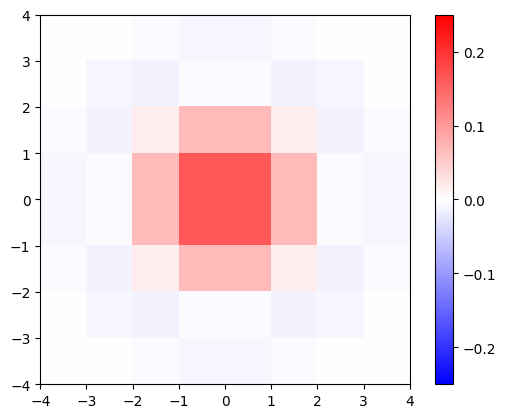

Frequency response:


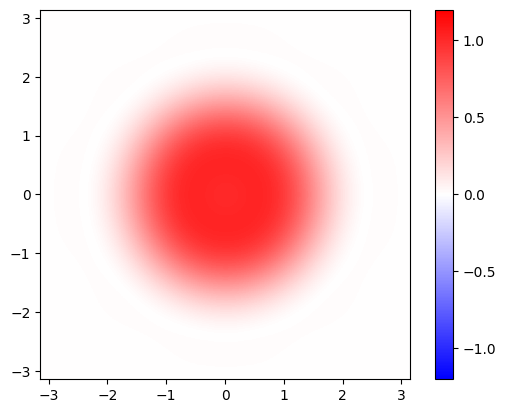

Odd size kernel:
Kernel:


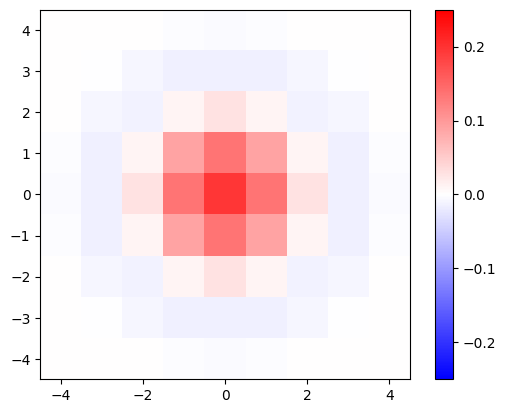

Frequency response:


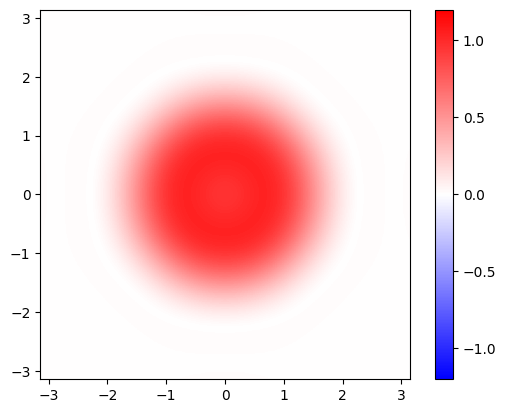

In [4]:
!ls
# Configuration
oversampling = 2  # Oversampling factor, 2 is a good choice
aa_even_kernel_size = 8 # Size of even sized antialiasing filter
aa_odd_kernel_size = aa_even_kernel_size + 1 # Size of odd sized antialiasing filter
accum_steps = 10
sub_batch_size = 2
discriminator_input_size = 1024
data_dir = "/content/drive/MyDrive/drone-image-analysis"
photos_dir = data_dir + "/photos_2022-05-14"
test_photos_dir = data_dir + "/test_photos"
mosaic_image_dir = data_dir + "/mosaics"

print("Even size kernel:")
test_kernel(windowed_circular_lowpass_kernel(np.pi/oversampling, aa_even_kernel_size))
print("Odd size kernel:")
test_kernel(windowed_circular_lowpass_kernel(np.pi/oversampling, aa_odd_kernel_size))

def channeled_kernel(kernel_prototype, num_channels):
  kernel_expanded = tf.expand_dims(kernel_prototype, 2)
  kernel_repeated = tf.repeat(kernel_expanded, num_channels, axis=2)
  return tf.expand_dims(kernel_repeated, -1)

def tensorflow_srgb_to_linear(image):
  return image*2 - 1

def numpy_linear_to_srgb(image):
  return (image + 1)/2

def load_and_filter_image(filepath, channeled_kernel):
  image = tf.io.decode_image(tf.io.read_file(filepath), channels=3, dtype=tf.float32)
  image = image + tf.random.uniform(image.shape, 0, 1/255) - tf.random.uniform(image.shape, 0, 1/255)
  image = tensorflow_srgb_to_linear(image)
  image = tf.nn.depthwise_conv2d([image], channeled_kernel, [1, 1, 1, 1], "VALID")[0]
  return image

In [5]:
try:
  train_dataset_filenames = tf.data.Dataset.list_files(photos_dir + "/*.jpg")
except:
  print("error")

print("Number of image files = " + str(train_dataset_filenames.cardinality().numpy()));
train_dataset = []
for filepath in train_dataset_filenames:
  train_dataset.append(load_and_filter_image(filepath, channeled_kernel(windowed_circular_lowpass_kernel(np.pi/oversampling, aa_even_kernel_size), 3)).numpy())
  print(train_dataset[-1].shape)
print("Length of train_dataset_images = " + str(len(train_dataset)));

Number of image files = 19
(4601, 3449, 3)
(4601, 3449, 3)
(4382, 3449, 3)
(4601, 3449, 3)
(4601, 3449, 3)
(4266, 3449, 3)
(4601, 3449, 3)
(4601, 3449, 3)
(4455, 3449, 3)
(4601, 3449, 3)
(4601, 3449, 3)
(4601, 3449, 3)
(4601, 3449, 3)
(4601, 3449, 3)
(4353, 3449, 3)
(4601, 3449, 3)
(4601, 3449, 3)
(4601, 3449, 3)
(4601, 3449, 3)
Length of train_dataset_images = 19


## Isotropic lowpass filtering layers
These layers apply a circularly symmetrical lowpass filter. They preserve spatial centering of the data to facilitate skip connections and center cropping in the network.

`IsotropicLowpassFilterLayer` accepts `strides = 1` to preserve the feature map size and `strides = 2` to downsample it to half size. With `strides = 1`, the kernel size must be odd. With downsampling, only even input and kernel sizes are supported, resulting in even-sized output. `cutoff` is the cutoff frequency (before downsampling).

`IsotropicLowpassFilteredUpsampleLayer` doubles the spatial size of the feature map. `cutoff` is the cutoff frequency after upsampling. `kernel_size` must be even.

In [6]:
class IsotropicLowpassFilterLayer(tf.keras.layers.Layer):
  def __init__(self, cutoff, kernel_size, strides = 1, **kwargs):
    super(IsotropicLowpassFilterLayer, self).__init__(**kwargs)
    self.kernel_size = kernel_size
    self.strides = strides
    assert self.strides == 1 or self.strides == 2, "Accepted values for strides are 1 and 2. Tuples or arrays are not accepted."
    if self.strides == 1:
      assert self.kernel_size % 2 == 1, "kernel_size must be odd when strides = 1"
    if self.strides == 2:
      assert self.kernel_size % 2 == 0, "kernel_size must be even when strides = 2"

    self.kernel_prototype = windowed_circular_lowpass_kernel(cutoff, self.kernel_size)

  def build(self, input_shape):
    self.filtering = tf.keras.layers.DepthwiseConv2D(self.kernel_size, trainable=False, use_bias=False, padding='same', strides=self.strides, weights=[channeled_kernel(self.kernel_prototype, input_shape[-1])])

  def call(self, inputs):
    return self.filtering(inputs)

def get_upsample_multiplication_tensor(input_shape):
  tile = tf.constant([[0, 0], [0, 4]], dtype=tf.float32)
  return tf.reshape(tf.tile(tile, [input_shape[-3], input_shape[-2]]), (1, input_shape[-3]*2, input_shape[-2]*2, 1))

class IsotropicLowpassFilteredUpsampleLayer(tf.keras.layers.Layer):
  def __init__(self, cutoff, kernel_size, **kwargs):
    super(IsotropicLowpassFilteredUpsampleLayer, self).__init__(**kwargs)
    self.kernel_size = kernel_size
    assert self.kernel_size % 2 == 0, "kernel_size must be even"
    self.multiply = tf.keras.layers.Multiply()
    #self.zeropadding = tf.keras.layers.ZeroPadding2D(padding = ((0, 1), (0, 1)))  # not needed for input even -> output even
    self.kernel_prototype = windowed_circular_lowpass_kernel(cutoff, kernel_size)
    self.kernel_size = kernel_size

  def build(self, input_shape):
    self.multiplication_tensor = get_upsample_multiplication_tensor(input_shape)
    self.filtering = tf.keras.layers.DepthwiseConv2D(self.kernel_size, trainable=False, use_bias=False, padding='same', weights=[channeled_kernel(self.kernel_prototype, input_shape[-1])])

  def call(self, inputs):
    x = tf.repeat(tf.repeat(inputs, repeats = 2, axis=2), repeats=2, axis=1)
    x = self.multiply([x, self.multiplication_tensor])
    #x = self.zeropadding(x)  # not needed for input even -> output even
    x = self.filtering(x)
    return x

if False:
  print("Test input:")
  input_shapes = (aa_odd_kernel_size + 2, aa_odd_kernel_size + 2, 3)
  eye = tf.repeat(tf.expand_dims(tf.repeat(tf.expand_dims(tf.eye(input_shapes[0], input_shapes[1]), -1), repeats = input_shapes[2], axis = -1), 0), repeats = batch_size, axis = 0)
  plt.imshow(eye[0])
  plt.show()

  def TestModel(input_shapes):
    inputs = tf.keras.Input(input_shapes)
    outputs = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size)(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

  print("Isotropic lowpass filtered:")
  model = TestModel(input_shapes)
  output = model(eye)
  plt.imshow(output[0])
  plt.show()

  def TestModel(input_shapes):
    inputs = tf.keras.Input(input_shapes)
    outputs = IsotropicLowpassFilteredUpsampleLayer(np.pi/oversampling, aa_even_kernel_size)(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

  print("Isotropic lowpass filtered upsampled:")
  model = TestModel(input_shapes)
  output = model(eye)
  plt.imshow(output[0])
  plt.show()

## RandomCropper
Crop images randomly. This should be done in the beginning of each epoch by calling RandomCropper.recrop()

In [7]:
import random

class RandomCropper:
  def __init__(self, images):
    self.images = images

  def recrop(self, size):
    image = random.choice(self.images)
    y = random.randrange(image.shape[0] - size)
    x = random.randrange(image.shape[1] - size)
    return image[y:y + size, x:x + size, :]

Sample training target image:


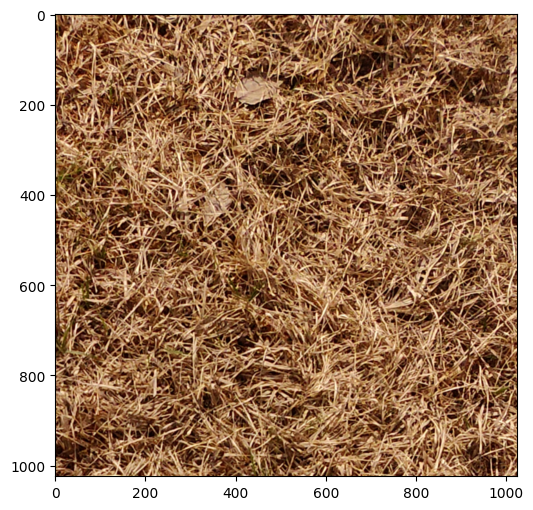

In [8]:
print("Sample training target image:")
train_dataset_cropper = RandomCropper(train_dataset)
train_image = train_dataset_cropper.recrop(discriminator_input_size)
plt.figure(figsize = (6,6))
plt.imshow(numpy_linear_to_srgb(train_image))
plt.show()

## Generator model
Define the generator network, parameterized by input image size.

Generator network:


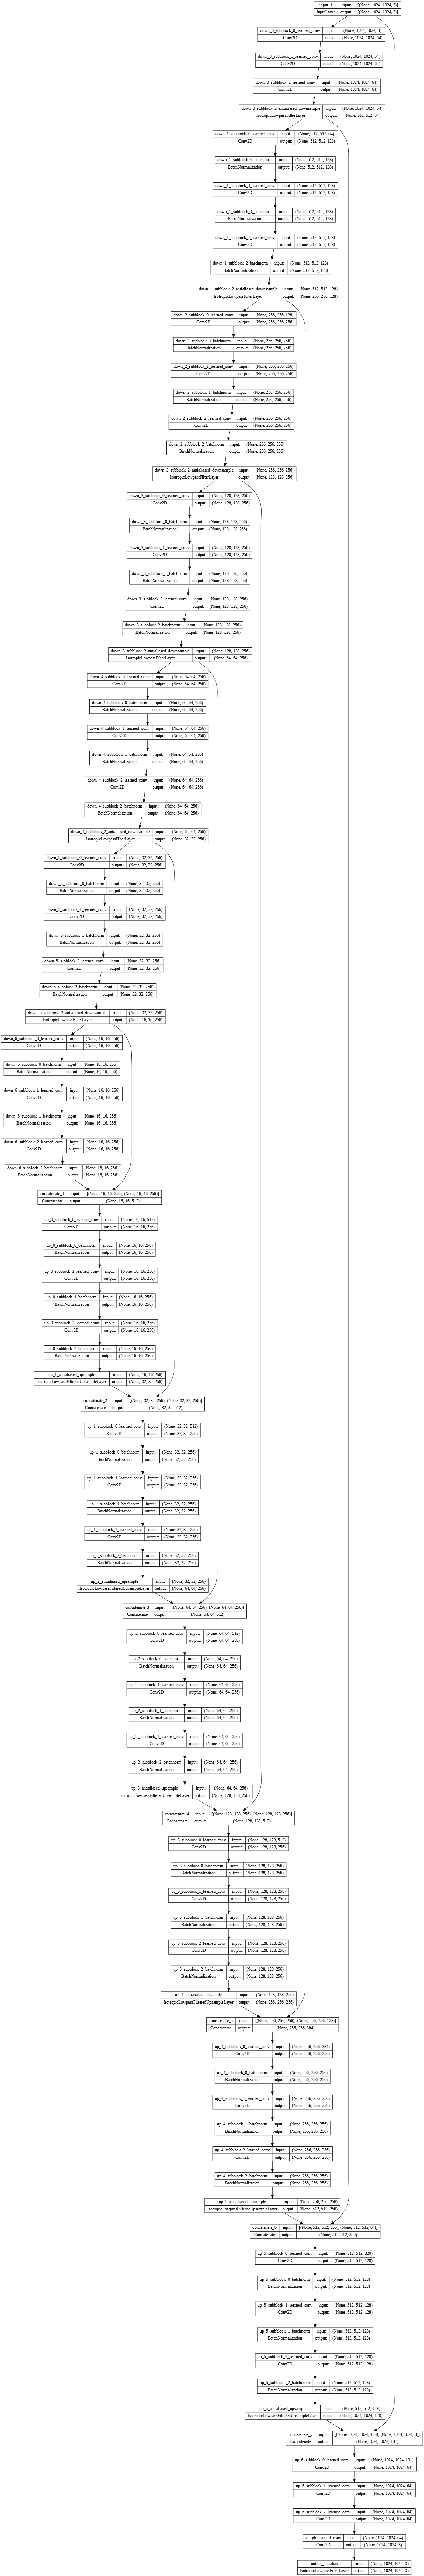

In [11]:
def Generator(input_size, down_nonlinearity, up_nonlinearity, initializer, learned_kernel_size, num_sublayers, num_resamplings, max_features, use_skip_connections):
  z = tf.keras.Input(shape = (input_size, input_size, 3), name = "random input")

  z = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size, name = "input_antialias")(z)
  x = z

  skip_connection_stack = []
  skip_connection_stack.append(x)

  n = 64
  for j in range(num_resamplings):
    for i in range(num_sublayers):
      conv_output_size = max_features if n > max_features else n
      x = tf.keras.layers.Conv2D(conv_output_size, learned_kernel_size, kernel_initializer=initializer, activation=down_nonlinearity, use_bias = False, padding="same", name = f"down_{j}_subblock_{i}_learned_conv")(x)
      if j > 0:
        x = tf.keras.layers.BatchNormalization(name = f"down_{j}_subblock_{i}_batchnorm")(x)
    if j < num_resamplings - 1:
      x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_even_kernel_size, strides = 2, name = f"down_{j}_subblock_{i}_antialiased_downsample")(x)
      if use_skip_connections:
        skip_connection_stack.append(x)
    n *= 2

  for j in range(num_resamplings):
    n //= 2
    if j > 0:
      x = IsotropicLowpassFilteredUpsampleLayer(np.pi/oversampling, aa_even_kernel_size, name = f"up_{j}_antialiased_upsample")(x)
    if use_skip_connections:
      skip_connection = skip_connection_stack.pop()
      x = tf.keras.layers.Concatenate()([x, skip_connection])
    for i in range(num_sublayers):
      conv_output_size = max_features if n > max_features else n
      x = tf.keras.layers.Conv2D(conv_output_size, learned_kernel_size, kernel_initializer=initializer, activation=up_nonlinearity, use_bias = False, padding="same", name = f"up_{j}_subblock_{i}_learned_conv")(x)
      if j < num_resamplings - 1:
        x = tf.keras.layers.BatchNormalization(name = f"up_{j}_subblock_{i}_batchnorm")(x)

  x = tf.keras.layers.Conv2D(3, learned_kernel_size, kernel_initializer=initializer, use_bias=False, padding="same", name = "to_rgb_learned_conv")(x)
  #x = tf.keras.layers.Activation("tanh", name = "output_nonlinearity")(x)
  x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_odd_kernel_size, name = "output_antialias")(x)
  #x = tf.keras.layers.CenterCrop(x.get_shape()[-3]//2, x.get_shape()[-2]//2, name = "output_crop")(x)

  return  tf.keras.Model(inputs=z, outputs=x)

generator_input_size = discriminator_input_size

initializer = tf.keras.initializers.HeNormal()
generator = Generator(generator_input_size, tf.keras.layers.LeakyReLU(), tf.keras.layers.LeakyReLU(), initializer, learned_kernel_size = 5, num_sublayers = 3, num_resamplings = 7, max_features = 256, use_skip_connections = True)
generator.build((generator_input_size, generator_input_size, 1))

print("Generator network:")
display(tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64))

In [12]:
# Generate, display
z = tf.random.normal((1, generator_input_size, generator_input_size, 3))

print("Sample training target image:")
train_image = train_dataset_cropper.recrop(generator_input_size)
plt.figure(figsize = (6,6))
plt.imshow(numpy_linear_to_srgb(train_image))
plt.show()

print("Generator input:")
plt.figure(figsize = (6,6))
plt.imshow((z[0].numpy() + 1)/2)
plt.show()
print("Generator output:")
x = generator(z, training = True)[0]
plt.imshow(numpy_linear_to_srgb(x.numpy()))
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Generator loss

In [13]:
mse = tf.keras.losses.MeanSquaredError() #tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Discriminator model

Discriminator network:


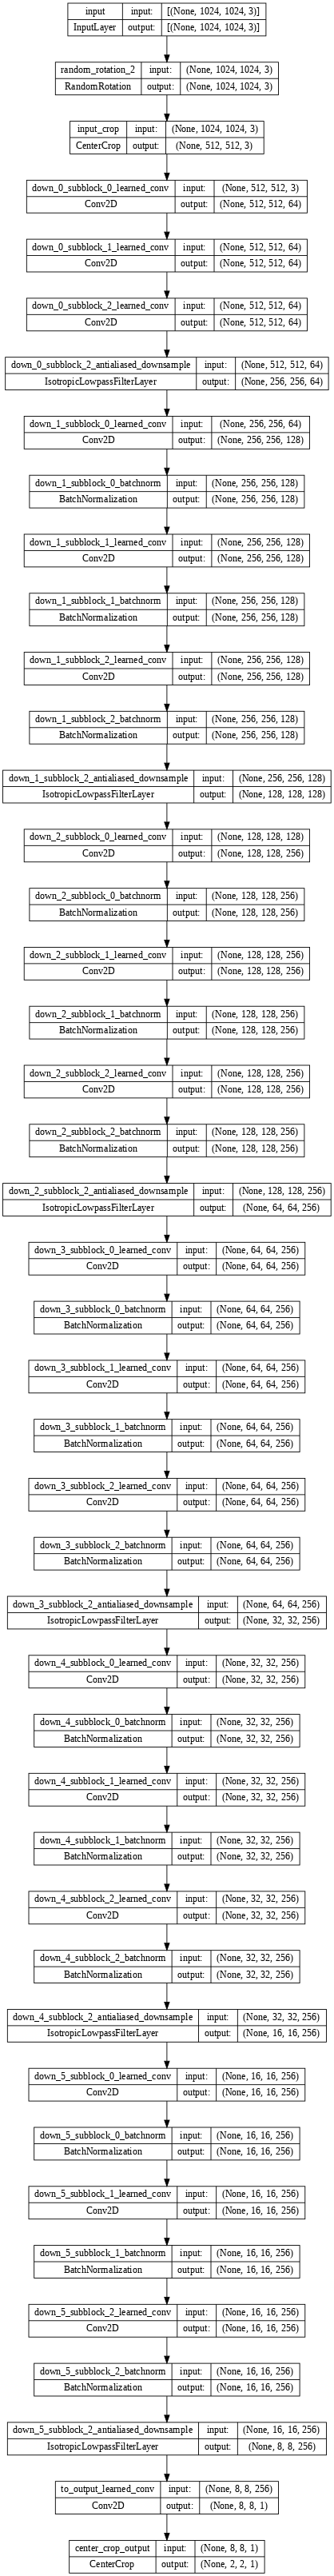

In [16]:
def Discriminator(input_size, down_nonlinearity, initializer, learned_kernel_size, num_sublayers, num_resamplings, max_features):
    inputs = tf.keras.Input(shape = (input_size, input_size, 3), name = "input")

    x = inputs

    x = tf.keras.layers.RandomRotation(0.5, fill_mode='constant')(x)
    x = tf.keras.layers.CenterCrop(x.get_shape()[-3]//2, x.get_shape()[-2]//2, name = "input_crop")(x)

    n = 64
    for j in range(num_resamplings):
        for i in range(num_sublayers):
            x = tf.keras.layers.Conv2D(max_features if n > max_features else n, learned_kernel_size, kernel_initializer=initializer, activation=down_nonlinearity, use_bias=True, padding="same", name = f"down_{j}_subblock_{i}_learned_conv")(x)
            if j > 0:
                x = tf.keras.layers.BatchNormalization(name = f"down_{j}_subblock_{i}_batchnorm")(x)
        x = IsotropicLowpassFilterLayer(np.pi/oversampling, aa_even_kernel_size, strides = 2, name = f"down_{j}_subblock_{i}_antialiased_downsample")(x)
        n *= 2

    x = tf.keras.layers.Conv2D(1, learned_kernel_size, kernel_initializer=initializer, use_bias=True, padding="same", name = "to_output_learned_conv")(x)
    x = tf.keras.layers.CenterCrop(2, 2, name = "center_crop_output")(x)

    return  tf.keras.Model(inputs=inputs, outputs=x)

discriminator = Discriminator(discriminator_input_size, tf.keras.layers.LeakyReLU(), initializer, learned_kernel_size = 5, num_sublayers = 3, num_resamplings = 6, max_features = 256)
discriminator.build((discriminator_input_size, discriminator_input_size, 3))

print("Discriminator network:")
display(tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64))


Sample training target image:


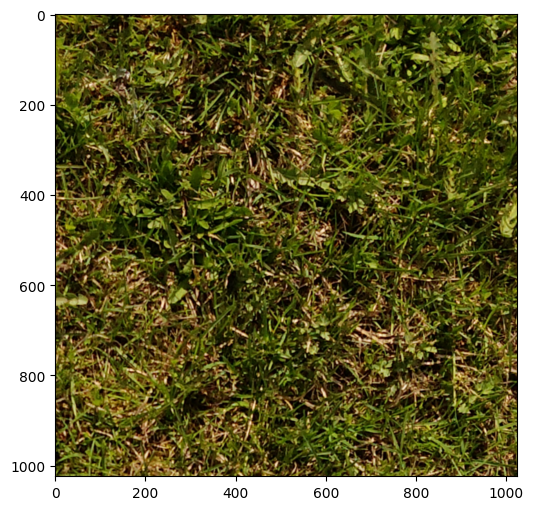

Discriminator output:


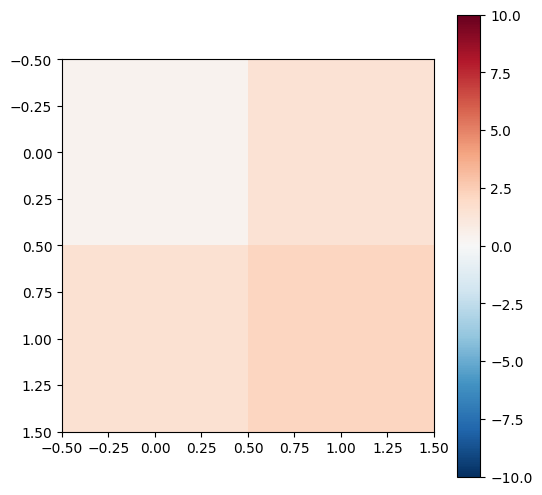

Sample generated image, before training:


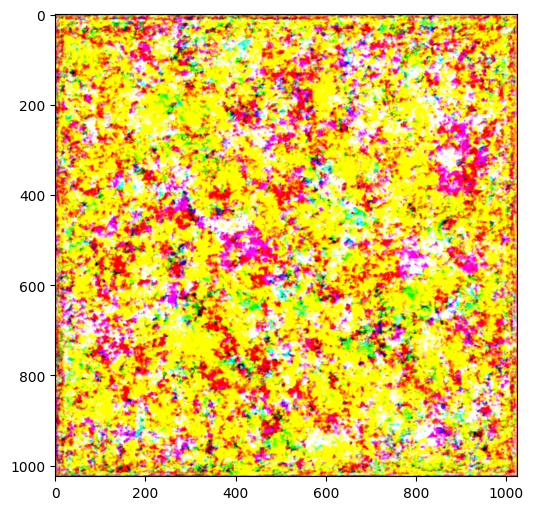

Discriminator output (for cropped generated image):


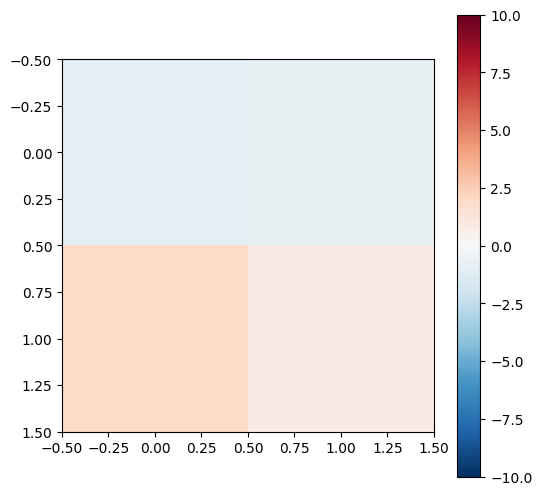

In [18]:
import tensorflow_addons as tfa
z = tf.random.normal((1, generator_input_size, generator_input_size, 3))

print("Sample training target image:")
train_image = train_dataset_cropper.recrop(generator_input_size)
plt.figure(figsize = (6,6))
plt.imshow(numpy_linear_to_srgb(train_image))
plt.show()

print("Discriminator output:")
disc_out = discriminator(train_image[tf.newaxis, ...], training=True)
plt.figure(figsize = (6,6))
plt.imshow(disc_out[0, ..., -1], cmap='RdBu_r')
plt.clim(-10,10)
plt.colorbar()
plt.show()

print("Sample generated image, before training:")
generated_image = generator(z, training = True)[0]
plt.figure(figsize = (6,6))
plt.imshow(numpy_linear_to_srgb(generated_image.numpy()))
plt.show()

print("Discriminator output (for cropped generated image):")
disc_out = discriminator(tf.keras.layers.CenterCrop(discriminator_input_size, discriminator_input_size)(generated_image)[tf.newaxis, ...], training=True)
plt.figure(figsize = (6,6))
plt.imshow(disc_out[0, ..., -1], cmap='RdBu_r')
plt.clim(-10,10)
plt.colorbar()
plt.show()

## Discriminator loss

## Optimizers

In [19]:
# tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.5, beta_2=0.99, epsilon=1e-07)
#generator_optimizer = tf.keras.optimizers.Adam(2e-5, beta_1=0.5)
#discriminator_optimizer = tf.keras.optimizers.Adam(2e-5, beta_1=0.5)
generator_optimizer = tf.keras.optimizers.SGD(1e-5) # start with 1e-3, then change it to 1e-4
discriminator_optimizer = tf.keras.optimizers.SGD(1e-5)

## Set up model checkpoint loading or saving

In [21]:
experiment_name = "GAN_train_2023-10-09"

In [22]:
checkpoint_dir = data_dir + '/training_checkpoints_' + experiment_name + "_"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator=generator, discriminator=discriminator)

## Load checkpoint

In [ ]:
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
#checkpoint.restore("/content/drive/MyDrive/drone-image-analysis/training_checkpoints_GAN_train_2022-05-14_/ckpt-14")

## Save checkpoint

In [ ]:
#checkpoint.save(file_prefix=checkpoint_prefix) #! good: /content/drive/MyDrive/drone-image-analysis/training_checkpoints_GAN_train_2022-05-14_/ckpt-16

## Train the GAN

In [ ]:
accum_size = 1
batch_size = 1

num_epochs = 10000
display_every = 1 # How many epochs to skip between data displays
save_checkpoint_every = 100

#checkpoint.save(file_prefix=checkpoint_prefix)
#checkpoint.restore(file_prefix=checkpoint_prefix)

#  with summary_writer.as_default():
#    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
#    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

@tf.function # (jit_compile=True)
def train_step(training_image_batch):
    gen_accum_gradient = [tf.zeros_like(var) for var in generator.trainable_variables]
    disc_accum_gradient = [tf.zeros_like(var) for var in discriminator.trainable_variables]

    for i in range(accum_size):

      z = tf.random.normal((batch_size, generator_input_size, generator_input_size, 3))
      disc_real_input = training_image_batch

      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        disc_real_output = discriminator(disc_real_input, training=True)

        gen_output = generator(z, training=True)
        disc_fake_input = gen_output
        disc_generated_output = discriminator(disc_fake_input, training=True)

        gen_adversarial_loss = mse(tf.ones_like(disc_generated_output), disc_generated_output)
        gen_loss = gen_adversarial_loss

        disc_loss = (mse(tf.ones_like(disc_real_output), disc_real_output) + mse(tf.math.negative(tf.ones_like(disc_generated_output)), disc_generated_output)) / 2

      gen_gradient = gen_tape.gradient(gen_loss, generator.trainable_variables)
      disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

      generator_optimizer.apply_gradients(zip(gen_gradient, generator.trainable_variables))
      discriminator_optimizer.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))


#      gen_accum_gradient = [(accum_grad+grad) for accum_grad, grad in zip(gen_accum_gradient, gen_gradient)]
#      disc_accum_gradient = [(accum_grad+grad) for accum_grad, grad in zip(disc_accum_gradient, disc_gradient)]

#    gen_accum_gradient = [grad/accum_size for grad in gen_accum_gradient]
#    disc_accum_gradient = [grad/accum_size for grad in disc_accum_gradient]

#    generator_optimizer.apply_gradients(zip(gen_accum_gradient, generator.trainable_variables))
#    discriminator_optimizer.apply_gradients(zip(disc_accum_gradient, discriminator.trainable_variables))

    return gen_output

def fit():
  for epoch in range(num_epochs + 1):
    for i in range(accum_size):
      training_image_batch = []

      for j in range(batch_size):
        training_image_batch.append(train_dataset_cropper.recrop(generator_input_size))# * np.random.lognormal(0, 0.01))

      training_image_batch = tf.stack(training_image_batch)

      gen_output = train_step(training_image_batch)

    if epoch % display_every == 0:
      clear_output(wait=True)
      plt.figure(figsize = (6, 6))
      plt.imshow(numpy_linear_to_srgb(tf.keras.layers.CenterCrop(512, 512)(gen_output)[0].numpy()))
      plt.show()

    if (epoch + 1) % save_checkpoint_every == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

fit()